In [1]:
from __future__ import print_function
import mxnet as mx
import numpy as np
import optimizer
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from mxnet.gluon.data import DataLoader, ArrayDataset
import matplotlib.pyplot as plt
%matplotlib inline
def set_seed(seed):
    np.random.seed(seed)
    mx.random.seed(seed)

In [2]:
data_ctx = mx.cpu()
#model_ctx = mx.cpu()
model_ctx = mx.gpu(2)

num_inputs = 784
num_outputs = 10
batch_size = 64
N_train = 60000
N_test = 10000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

train_data = gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      N_train, shuffle=True)
test_data = gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                                     N_test, shuffle=False)
for i, (data, label) in enumerate(train_data):
    print(i)
a=label.asnumpy()
data=data.asnumpy()
trdata7=data[a==7]
trdata8=data[a==8]
for i, (data, label) in enumerate(test_data):
    print(i)
a=label.asnumpy()
data=data.asnumpy()
tedata7=data[a==7]
tedata8=data[a==8]
X_tr=np.concatenate([trdata7,trdata8],axis=0).reshape((-1,784))
#X_tr=np.concatenate([X_tr,np.ones([X_tr.shape[0],1])],axis=1)
y_tr=np.concatenate([np.zeros(trdata7.shape[0]),np.zeros(trdata8.shape[0])+1])
y_tr=y_tr.reshape(len(y_tr),1)
X_te=np.concatenate([tedata7,tedata8],axis=0).reshape((-1,784))
#X_te=np.concatenate([X_te,np.ones([X_te.shape[0],1])],axis=1)
y_te=np.concatenate([np.zeros(tedata7.shape[0]),np.zeros(tedata8.shape[0])+1])
y_te=y_te.reshape(len(y_te),1)

0
0


In [3]:
batch_size=200
train_dataset = ArrayDataset(X_tr, np.float32(y_tr))
train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,last_batch='discard')


In [4]:
ctx=model_ctx
epochs = 2
Xtr_nd = nd.array(X_tr).as_in_context(ctx)
ytr_nd = nd.array(y_tr).as_in_context(ctx)
Xte_nd = nd.array(X_te).as_in_context(ctx)
yte_nd = nd.array(y_te).as_in_context(ctx)
metric = mx.metric.Accuracy()
loss_function = gluon.loss.LogisticLoss(label_format='binary') 

In [5]:
def trainLA(optimizername):
    set_seed(1)
    net=nn.Sequential()
    net.add(nn.Dense(500,activation='relu'),nn.Dense(90,activation='relu'),nn.Dense(30,activation='relu'),nn.Dense(1, activation=None))
    net.initialize(mx.init.MSRAPrelu(), ctx=ctx)
    for i, (data, label) in enumerate(train_data):
        aa=net(data.as_in_context(ctx))
        break
    trainer = gluon.Trainer(
        net.collect_params(),
        optimizername,
        {'learning_rate': 0.01 ,'k':10, 'alpha':0.5} 
    )
    
    loss_function = gluon.loss.LogisticLoss(label_format='binary') 

    LASGD_trainerr=[]
    LASGD_testacc=[]

    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
           # print(i)
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss=loss_function(output, label)
            loss.backward()
            trainer.step(batch_size)#,ignore_stale_grad=True) ###ignore
            cumulative_loss += nd.mean(loss).asscalar()
            trainloss=sum(loss_function(net(Xtr_nd),ytr_nd)).asscalar()
            LASGD_trainerr.append(trainloss)
            testacc=sum(((net(Xte_nd)>0)-yte_nd)==0)/len(yte_nd)
            LASGD_testacc.append(testacc.asscalar())
            print('trainloss:',trainloss,'testacc',testacc)

        if e%1==0:
            print(e)
    return LASGD_testacc,LASGD_trainerr

In [6]:
def train(optimizername):
    ctx=model_ctx
    set_seed(1)
    net=nn.Sequential()
    net.add(nn.Dense(500,activation='relu'),nn.Dense(90,activation='relu'),nn.Dense(30,activation='relu'),nn.Dense(1, activation=None))
    net.initialize(mx.init.MSRAPrelu(), ctx=ctx)
    #net[1].initialize(mx.initializer.One(),ctx=ctx,force_reinit=True)
    for i, (data, label) in enumerate(train_data):
        aa=net(data.as_in_context(ctx))
        break
    #optimizer.LookaheadSGD(k=5, alpha=0.5, learning_rate=1e-3)
    trainer = gluon.Trainer(
        net.collect_params(),
        optimizername,
        {'learning_rate': 0.01 },
    #    optimizer_params = {'learning_rate': 0.01,'beta1': 0.9} , 
    )
    SGD_trainerr=[]
    SGD_testacc=[]

    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
           # print(i)
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss=loss_function(output, label)
            loss.backward()
            trainer.step(batch_size)#,ignore_stale_grad=True) ###ignore
            cumulative_loss += nd.mean(loss).asscalar()
            trainloss=sum(loss_function(net(Xtr_nd),ytr_nd)).asscalar()
            SGD_trainerr.append(trainloss)
            testacc=sum(((net(Xte_nd)>0)-yte_nd)==0)/len(yte_nd)
            SGD_testacc.append(testacc.asscalar())
            print('trainloss:',trainloss,'testacc',testacc)

        if e%1==0:
            print(e)
    return SGD_testacc, SGD_trainerr

In [7]:
for i in ['sgd','adam','rmsprop']:
    exec(i+"te,"+i+"tr=train('"+i+"')") 
    exec("LA"+i+"te,"+"LA"+i+"tr=trainLA('"+"lookahead"+i+"')") 

trainloss: 8984.859 testacc 
[0.53646356]
<NDArray 1 @gpu(2)>
trainloss: 8220.255 testacc 
[0.6078921]
<NDArray 1 @gpu(2)>
trainloss: 7513.8174 testacc 
[0.6833167]
<NDArray 1 @gpu(2)>
trainloss: 6970.81 testacc 
[0.7377622]
<NDArray 1 @gpu(2)>
trainloss: 6481.0083 testacc 
[0.7752248]
<NDArray 1 @gpu(2)>
trainloss: 6048.2637 testacc 
[0.8021978]
<NDArray 1 @gpu(2)>
trainloss: 5612.5522 testacc 
[0.82617384]
<NDArray 1 @gpu(2)>
trainloss: 5231.1562 testacc 
[0.84665334]
<NDArray 1 @gpu(2)>
trainloss: 4891.0005 testacc 
[0.8611389]
<NDArray 1 @gpu(2)>
trainloss: 4574.1533 testacc 
[0.86913085]
<NDArray 1 @gpu(2)>
trainloss: 4277.266 testacc 
[0.8856144]
<NDArray 1 @gpu(2)>
trainloss: 4023.0999 testacc 
[0.8961039]
<NDArray 1 @gpu(2)>
trainloss: 3799.0369 testacc 
[0.9025974]
<NDArray 1 @gpu(2)>
trainloss: 3612.8618 testacc 
[0.9070929]
<NDArray 1 @gpu(2)>
trainloss: 3428.4065 testacc 
[0.9110889]
<NDArray 1 @gpu(2)>
trainloss: 3258.885 testacc 
[0.9150849]
<NDArray 1 @gpu(2)>
trainloss:

trainloss: 4863.726 testacc 
[0.86213785]
<NDArray 1 @gpu(2)>
trainloss: 4548.1436 testacc 
[0.8706294]
<NDArray 1 @gpu(2)>
trainloss: 4242.519 testacc 
[0.8861139]
<NDArray 1 @gpu(2)>
trainloss: 3996.731 testacc 
[0.8981019]
<NDArray 1 @gpu(2)>
trainloss: 3769.3726 testacc 
[0.9035964]
<NDArray 1 @gpu(2)>
trainloss: 3582.0615 testacc 
[0.9060939]
<NDArray 1 @gpu(2)>
trainloss: 4787.371 testacc 
[0.85764235]
<NDArray 1 @gpu(2)>
trainloss: 4457.196 testacc 
[0.87562436]
<NDArray 1 @gpu(2)>
trainloss: 4178.7524 testacc 
[0.8851149]
<NDArray 1 @gpu(2)>
trainloss: 3919.7957 testacc 
[0.8961039]
<NDArray 1 @gpu(2)>
trainloss: 3711.4275 testacc 
[0.9020979]
<NDArray 1 @gpu(2)>
trainloss: 3508.5723 testacc 
[0.9125874]
<NDArray 1 @gpu(2)>
trainloss: 3340.5173 testacc 
[0.9140859]
<NDArray 1 @gpu(2)>
trainloss: 3167.8455 testacc 
[0.92057943]
<NDArray 1 @gpu(2)>
trainloss: 3033.0837 testacc 
[0.92457545]
<NDArray 1 @gpu(2)>
trainloss: 2898.2263 testacc 
[0.9285714]
<NDArray 1 @gpu(2)>
trainlos

trainloss: 527.88934 testacc 
[0.9795205]
<NDArray 1 @gpu(2)>
trainloss: 398.47787 testacc 
[0.9845155]
<NDArray 1 @gpu(2)>
trainloss: 446.7135 testacc 
[0.98351645]
<NDArray 1 @gpu(2)>
trainloss: 487.1856 testacc 
[0.98301697]
<NDArray 1 @gpu(2)>
trainloss: 461.328 testacc 
[0.984016]
<NDArray 1 @gpu(2)>
trainloss: 414.38925 testacc 
[0.98551446]
<NDArray 1 @gpu(2)>
trainloss: 415.04694 testacc 
[0.985015]
<NDArray 1 @gpu(2)>
trainloss: 409.9005 testacc 
[0.9845155]
<NDArray 1 @gpu(2)>
trainloss: 408.32867 testacc 
[0.9845155]
<NDArray 1 @gpu(2)>
trainloss: 581.8488 testacc 
[0.98301697]
<NDArray 1 @gpu(2)>
trainloss: 852.01373 testacc 
[0.97652346]
<NDArray 1 @gpu(2)>
trainloss: 701.3566 testacc 
[0.98002]
<NDArray 1 @gpu(2)>
trainloss: 335.53024 testacc 
[0.989011]
<NDArray 1 @gpu(2)>
trainloss: 416.1926 testacc 
[0.987013]
<NDArray 1 @gpu(2)>
trainloss: 715.37866 testacc 
[0.984016]
<NDArray 1 @gpu(2)>
trainloss: 549.4613 testacc 
[0.98551446]
<NDArray 1 @gpu(2)>
trainloss: 374.186

trainloss: 448.6166 testacc 
[0.9775225]
<NDArray 1 @gpu(2)>
trainloss: 304.9194 testacc 
[0.98301697]
<NDArray 1 @gpu(2)>
trainloss: 253.34383 testacc 
[0.98351645]
<NDArray 1 @gpu(2)>
trainloss: 266.11542 testacc 
[0.98551446]
<NDArray 1 @gpu(2)>
trainloss: 321.35977 testacc 
[0.9845155]
<NDArray 1 @gpu(2)>
trainloss: 299.1393 testacc 
[0.9865135]
<NDArray 1 @gpu(2)>
trainloss: 278.41473 testacc 
[0.9865135]
<NDArray 1 @gpu(2)>
trainloss: 246.21698 testacc 
[0.987013]
<NDArray 1 @gpu(2)>
trainloss: 243.59914 testacc 
[0.9865135]
<NDArray 1 @gpu(2)>
trainloss: 265.65195 testacc 
[0.987013]
<NDArray 1 @gpu(2)>
trainloss: 297.65497 testacc 
[0.98551446]
<NDArray 1 @gpu(2)>
trainloss: 302.4694 testacc 
[0.98351645]
<NDArray 1 @gpu(2)>
trainloss: 299.87946 testacc 
[0.984016]
<NDArray 1 @gpu(2)>
trainloss: 291.11652 testacc 
[0.98551446]
<NDArray 1 @gpu(2)>
trainloss: 250.74574 testacc 
[0.98751247]
<NDArray 1 @gpu(2)>
trainloss: 219.85553 testacc 
[0.9895105]
<NDArray 1 @gpu(2)>
trainlos

trainloss: 255.66211 testacc 
[0.9885115]
<NDArray 1 @gpu(2)>
trainloss: 235.40105 testacc 
[0.98751247]
<NDArray 1 @gpu(2)>
trainloss: 199.86903 testacc 
[0.9905095]
<NDArray 1 @gpu(2)>
trainloss: 218.37799 testacc 
[0.989011]
<NDArray 1 @gpu(2)>
trainloss: 199.3246 testacc 
[0.989011]
<NDArray 1 @gpu(2)>
trainloss: 194.56865 testacc 
[0.99000996]
<NDArray 1 @gpu(2)>
trainloss: 231.09885 testacc 
[0.9895105]
<NDArray 1 @gpu(2)>
trainloss: 347.3666 testacc 
[0.98551446]
<NDArray 1 @gpu(2)>
trainloss: 710.4617 testacc 
[0.97252744]
<NDArray 1 @gpu(2)>
0
trainloss: 436.3453 testacc 
[0.9825175]
<NDArray 1 @gpu(2)>
trainloss: 443.57782 testacc 
[0.9795205]
<NDArray 1 @gpu(2)>
trainloss: 1643.3274 testacc 
[0.964036]
<NDArray 1 @gpu(2)>
trainloss: 5680.3364 testacc 
[0.8541458]
<NDArray 1 @gpu(2)>
trainloss: 16674.156 testacc 
[0.73576427]
<NDArray 1 @gpu(2)>
trainloss: 4541.343 testacc 
[0.83666337]
<NDArray 1 @gpu(2)>
trainloss: 516.52484 testacc 
[0.9795205]
<NDArray 1 @gpu(2)>
trainlos

trainloss: 371.62128 testacc 
[0.97902095]
<NDArray 1 @gpu(2)>
trainloss: 351.6475 testacc 
[0.98301697]
<NDArray 1 @gpu(2)>
trainloss: 445.3355 testacc 
[0.97902095]
<NDArray 1 @gpu(2)>
trainloss: 362.1584 testacc 
[0.982018]
<NDArray 1 @gpu(2)>
trainloss: 290.86224 testacc 
[0.982018]
<NDArray 1 @gpu(2)>
trainloss: 400.4654 testacc 
[0.98002]
<NDArray 1 @gpu(2)>
trainloss: 316.08267 testacc 
[0.98002]
<NDArray 1 @gpu(2)>
trainloss: 295.7678 testacc 
[0.9815185]
<NDArray 1 @gpu(2)>
trainloss: 303.30676 testacc 
[0.9795205]
<NDArray 1 @gpu(2)>
trainloss: 286.0784 testacc 
[0.9825175]
<NDArray 1 @gpu(2)>
trainloss: 280.05975 testacc 
[0.9805195]
<NDArray 1 @gpu(2)>
trainloss: 267.85907 testacc 
[0.9845155]
<NDArray 1 @gpu(2)>
trainloss: 312.7032 testacc 
[0.98002]
<NDArray 1 @gpu(2)>
trainloss: 254.09341 testacc 
[0.9805195]
<NDArray 1 @gpu(2)>
trainloss: 280.28827 testacc 
[0.985015]
<NDArray 1 @gpu(2)>
trainloss: 272.43423 testacc 
[0.98301697]
<NDArray 1 @gpu(2)>
trainloss: 252.9161 

In [37]:
LAsgdte

[0.52747256,
 0.6043956,
 0.6768232,
 0.73176825,
 0.77672327,
 0.8056943,
 0.82867134,
 0.84815186,
 0.86013985,
 0.7217782,
 0.7777223,
 0.8201798,
 0.84865135,
 0.8611389,
 0.8721279,
 0.8836164,
 0.8941059,
 0.9040959,
 0.9100899,
 0.85964036,
 0.87562436,
 0.8881119,
 0.9020979,
 0.9085914,
 0.9140859,
 0.9190809,
 0.9230769,
 0.9275724,
 0.9300699,
 0.9100899,
 0.9170829,
 0.92007995,
 0.9230769,
 0.92907095,
 0.9300699,
 0.9330669,
 0.9345654,
 0.93656343,
 0.93656343,
 0.93106896,
 0.93356645,
 0.93356645,
 0.93556446,
 0.9370629,
 0.9395604,
 0.9415584,
 0.9415584,
 0.94305694,
 0.9435564,
 0.9390609,
 0.9415584,
 0.94205797,
 0.9440559,
 0.94305694,
 0.94505495,
 0.94455546,
 0.94555444,
 0.94705296,
 0.94905096,
 0.94455546]

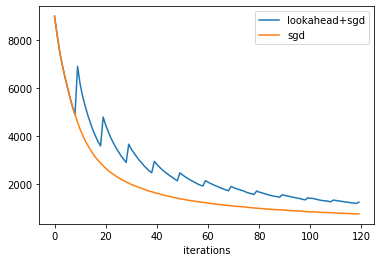

In [8]:

plt.plot(LAsgdtr)
plt.plot(sgdtr)
plt.legend(['lookahead+sgd','sgd'])
plt.xlabel('iterations')
plt.savefig('mnistNNsgd.png')
# plt.plot(LAadamtr)
# plt.plot(adamtr)
# plt.legend(['lookahead+adam','adam'])
# plt.xlabel('iterations')

# plt.plot(LArmsproptr)
# plt.plot(rmsproptr)
# plt.legend(['lookahead+rmsprop','rmsprop'])
# plt.xlabel('iterations')
#plt.show()
#plt.savefig('batchsize200MNIST.png')

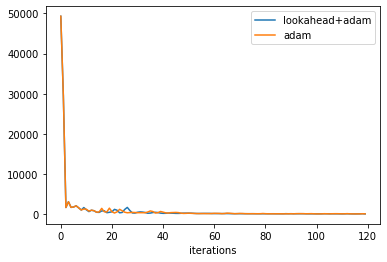

In [9]:
plt.plot(LAadamtr)
plt.plot(adamtr)
plt.legend(['lookahead+adam','adam'])
plt.xlabel('iterations')
plt.savefig('mnistNNadam.png')

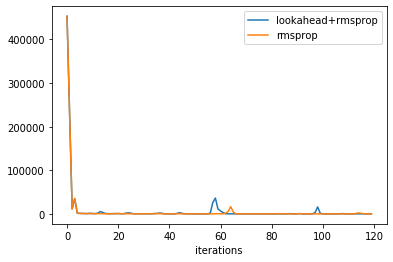

In [10]:
plt.plot(LArmsproptr)
plt.plot(rmsproptr)
plt.legend(['lookahead+rmsprop','rmsprop'])
plt.xlabel('iterations')
plt.savefig('mnistNNrmsprop.png')